# 重新开始测试
## 导入需要的包

In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# 定义参数，导入训练测试集

In [2]:
# 定义超参数
image_size = 28 #图像尺寸大小
input_dim = 100 #输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
num_channels = 1# 图像的通道数
num_features = 64 #生成器中间的卷积核数量
batch_size = 64 #批次大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
                            download=True) #当找不到文件的时候，自动下载

# 加载测试数据集
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,   #训练集
                                           batch_size=batch_size,   #批次大小
                                           shuffle=True)  #打乱

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''


# 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
indices = range(len(test_dataset))  #测试长度
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)  #采样
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )


D:\Anaconda\envs\test\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# 构造判别器

In [19]:
# 构造判别器
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD,self).__init__()
        self.model=nn.Sequential() #序列化模块构造的神经网络
        self.model.add_module('conv1',nn.Conv2d(num_channels, num_features, 5, 2, 0, bias=False)) #卷积层
        self.model.add_module('relu1',nn.ReLU()) #激活函数使用了ReLu
        #self.model.add_module('relu1',nn.LeakyReLU(0.2, inplace = True)) #激活函数使用了leakyReLu，可以防止dead ReLu的问题
        
        #第二层卷积
        self.model.add_module('conv2',nn.Conv2d(num_features, num_features * 2, 5, 2, 0, bias=False))
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features * 2)) 
        self.model.add_module('linear1', nn.Linear(num_features * 2 * 4 * 4,   #全链接网络层
                                                   num_features))
        self.model.add_module('linear2', nn.Linear(num_features, 1)) #全链接网络层
        self.model.add_module('sigmoid',nn.Sigmoid())
    def forward(self,input):
        output = input
        # 对网络中的所有神经模块进行循环，并挑选出特定的模块linear1，将feature map展平
        for name, module in self.model.named_children():
            if name == 'linear1':
                output = output.view(-1, num_features * 2 * 4 * 4)
            output = module(output)
        return output.view(-1)

# 定义生成器

In [77]:
#生成器模型定义

class ModelG(nn.Module):
    def __init__(self):
        super(ModelG,self).__init__()
        self.model=nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        # 增加非线性层
        self.model.add_module('relu1',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm2',nn.BatchNorm2d(num_features))
        # 增加非线性层
        self.model.add_module('relu2',nn.ReLU(True))

        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        #self.model.add_module('tanh',nn.Tanh())
        self.model.add_module('sigmoid',nn.Sigmoid())
    def forward(self,input):
        output = input
        
        #遍历网络的所有层，一层层输出信息
        for name, module in self.model.named_children():
            output = module(output)
        #输出一张28*28的图像
        return(output)


def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        m.weight.data.normal_(0,0.02)
    if class_name.find('norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img
def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)


# 开始加入噪声进行对抗训练

In [ ]:
# 构建一个生成器模型，并加载到GPU上
netG = ModelG().cuda() if use_cuda else ModelG()
# 初始化网络的权重
netG.apply(weight_init)
print(netG)

# 构建一个辨别器网络，并加载的GPU上
netD=ModelD().cuda() if use_cuda else ModelD()
# 初始化权重
netD.apply(weight_init)

# 要优化两个网络，所以需要有两个优化器
# 使用Adam优化器，可以自动调节收敛速度
#optimizerD=optim.SGD(netD.parameters(),lr=0.0002)
#optimizerG=optim.SGD(netG.parameters(),lr=0.0002)
optimizerD=optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))  #优化器
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))


# 模型的输入输出
# 生成一个随机噪声输入给生成器
noise=torch.tensor((batch_size, input_dim, 1, 1), dtype = torch.float)
print("随机噪声",noise)
#固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
print("固定噪声",fixed_noise)
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()


#BCE损失函数
criterion=nn.BCELoss()
error_G = None #总误差
num_epochs = 100#训练周期
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
     #   print("data",data)
     #   print("target",target)
        #训练辨别器网络
        #清空梯度
        optimizerD.zero_grad()
        #1、输入真实图片
        data,target = data.clone().detach().requires_grad_(True), target.clone().detach()
      #  print("data",data)
      #  print("target",target)
        # 用于鉴别赝品还是真品的标签
        label = torch.ones(data.size()[0])  #正确的标签是1（真实）
        label = label.cuda() if use_cuda else label
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
        netD.train()
        
        output=netD(data) #放到辨别网络里辨别
        
        
        #计算损失函数
        label.data.fill_(1)
        error_real=criterion(output, label)  #损失函数
        error_real.backward() #辨别器的反向误差传播
        D_x=output.data.mean()
        
        #2、用噪声生成一张假图片
        with torch.no_grad():
            noise.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1) #噪声是一个input_dim维度的向量
        #喂给生成器生成图像
        fake_pic=netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2=netD(fake_pic) #用辨别器识别假图像
        label.data.fill_(0) #正确的标签应该是0（伪造）
        error_fake=criterion(output2,label) #计算损失函数
        error_fake.backward() #反向传播误差
        error_D=error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step() #开始优化
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad() #清空生成器梯度

            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1) #分类标签全部标为1，即真实图像
            noise.data.normal_(0,1) #重新随机生成一个噪声向量
            netG.train()
            fake_pic=netG(noise) #生成器生成一张伪造图像
            output=netD(fake_pic) #辨别器进行分辨
            error_G=criterion(output,label) #辨别器的损失函数
            error_G.backward() #反向传播
            optimizerG.step() #优化网络
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        # 记录数据
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader),
                error_D.data.item(), 
                error_G.data.item()))
    #生成一些随机图片，但因输出到文件
    netG.eval()
    fake_u=netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)

    #挑选一些真实数据中的图像图像保存
    data, _ = next(iter(train_loader))
    vutil.save_image(img,'temp/fake_%s.png'% (epoch))
    # 保存网络状态到硬盘文件
    torch.save(netG, '%s/netG_epoch_%d.pth' % ('net', epoch))
    torch.save(netD, '%s/netD_epoch_%d.pth' % ('net', epoch))
    if epoch == 0:
        img = make_show(data.clone().detach().requires_grad_(True))
        vutil.save_image(img,'temp/real_%s.png' % (epoch))

In [ ]:
#查看保存的参数

In [13]:
PATHG='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'
PATHD='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netD_epoch_99.pth'

netG = torch.load(PATHG)
netD = torch.load(PATHD)

#conv1_weight_state.eval()
print("netG",netG)
print('netD',netD)

netG OrderedDict([('model.deconv1.weight', tensor([[[[-0.0501,  0.0959,  0.0276,  0.1531, -0.0239],
          [ 0.0344,  0.0925,  0.0754,  0.0474,  0.0739],
          [ 0.0817,  0.0517, -0.0690,  0.0456,  0.0285],
          [ 0.0287, -0.0328, -0.0360,  0.0473,  0.0156],
          [ 0.0330, -0.0082,  0.0257,  0.1119,  0.0196]],

         [[-0.0108, -0.1002,  0.0168,  0.1137, -0.1452],
          [ 0.0202,  0.0207,  0.0429, -0.0648, -0.1093],
          [ 0.0245, -0.0579, -0.0173,  0.0042,  0.0647],
          [-0.0388, -0.0967, -0.0237, -0.0124,  0.0463],
          [-0.0661, -0.0048,  0.0144,  0.0464,  0.0206]],

         [[-0.0378,  0.0585,  0.1136, -0.0038,  0.0906],
          [ 0.0281,  0.0484,  0.0430, -0.0406,  0.0118],
          [ 0.0189,  0.0551, -0.0622, -0.0526,  0.0063],
          [-0.0087,  0.0733,  0.0452, -0.0431,  0.0555],
          [ 0.0540,  0.0977,  0.0089, -0.0341,  0.0631]],

         ...,

         [[-0.1326, -0.0497, -0.0329, -0.0206,  0.0187],
          [-0.0082, -0.0

# 尝试将整个模型保存下来，然后测试效果
## 这里本来是之前训练了一百次，但是因为卡死了，所以内容直接没有了，下面的是训练了一次的
### 但是之前训练了一百次的保存了参数，后面可以直接训练了第一百次的参数直接使用

In [29]:
# 构建一个生成器模型，并加载到GPU上
netG = ModelG().cuda() if use_cuda else ModelG()
# 初始化网络的权重
netG.apply(weight_init)
print(netG)

# 构建一个辨别器网络，并加载的GPU上
netD=ModelD().cuda() if use_cuda else ModelD()
# 初始化权重
netD.apply(weight_init)

# 要优化两个网络，所以需要有两个优化器
# 使用Adam优化器，可以自动调节收敛速度
#optimizerD=optim.SGD(netD.parameters(),lr=0.0002)
#optimizerG=optim.SGD(netG.parameters(),lr=0.0002)
optimizerD=optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))  #优化器
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))


# 模型的输入输出
# 生成一个随机噪声输入给生成器
noise=torch.tensor((batch_size, input_dim, 1, 1), dtype = torch.float)
print("随机噪声",noise)
#固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
print("固定噪声",fixed_noise)
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()


#BCE损失函数
criterion=nn.BCELoss()
error_G = None #总误差
num_epochs = 1 #训练周期
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
     #   print("data",data)
     #   print("target",target)
        #训练辨别器网络
        #清空梯度
        optimizerD.zero_grad()
        #1、输入真实图片
        data,target = data.clone().detach().requires_grad_(True), target.clone().detach()
      #  print("data",data)
      #  print("target",target)
        # 用于鉴别赝品还是真品的标签
        label = torch.ones(data.size()[0])  #正确的标签是1（真实）
        label = label.cuda() if use_cuda else label
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
        netD.train()
        
        output=netD(data) #放到辨别网络里辨别
        
        
        #计算损失函数
        label.data.fill_(1)
        error_real=criterion(output, label)  #损失函数
        error_real.backward() #辨别器的反向误差传播
        D_x=output.data.mean()
        
        #2、用噪声生成一张假图片
        with torch.no_grad():
            noise.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1) #噪声是一个input_dim维度的向量
        #喂给生成器生成图像
        fake_pic=netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2=netD(fake_pic) #用辨别器识别假图像
        label.data.fill_(0) #正确的标签应该是0（伪造）
        error_fake=criterion(output2,label) #计算损失函数
        error_fake.backward() #反向传播误差
        error_D=error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step() #开始优化
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad() #清空生成器梯度

            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1) #分类标签全部标为1，即真实图像
            noise.data.normal_(0,1) #重新随机生成一个噪声向量
            netG.train()
            fake_pic=netG(noise) #生成器生成一张伪造图像
            output=netD(fake_pic) #辨别器进行分辨
            error_G=criterion(output,label) #辨别器的损失函数
            error_G.backward() #反向传播
            optimizerG.step() #优化网络
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        # 记录数据
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader),
                error_D.data.item(), 
                error_G.data.item()))
    #生成一些随机图片，但因输出到文件
    netG.eval()
    fake_u=netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)

    #挑选一些真实数据中的图像图像保存
    data, _ = next(iter(train_loader))
    vutil.save_image(img,'temp/fake_test2%s.png'% (epoch))
    # 保存网络状态到硬盘文件
    torch.save(netG, '%s/netG_epoch_%d_all.pth' % ('net', epoch))
    torch.save(netD, '%s/netD_epoch_%d_all.pth' % ('net', epoch))
    if epoch == 0:
        img = make_show(data.clone().detach().requires_grad_(True))
        vutil.save_image(img,'temp/real_test2%s.png' % (epoch))

ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)
随机噪声 tensor([ 64., 100.,   1.,   1.])
固定噪声 tensor([[[[ 0.2666]],

         [[-0.0725]],

         [[-0.3885]],

         ...,

         [[ 0.2528]],

         [[ 0.9445]],

         [[ 0.1864]]],


        [[[ 1.1295]],

         [[-1.6687]],

         [[ 1.5345]],

         ...,

         [[-1.3179]],

         [[ 0.7141]],

         [[ 0.9342]]],


        [[[ 0.4410]],

         [[-0.5156]],

         [[ 1.1340]],

   

# 查看网络结构，保存的整个模型

In [30]:
PATHG='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_0_all.pth'
PATHD='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netD_epoch_0_all.pth'

netG = torch.load(PATHG)
netD = torch.load(PATHD)

#conv1_weight_state.eval()
print("netG",netG)
print('netD',netD)

netG ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)
netD ModelD(
  (model): Sequential(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (relu1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=2048, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=

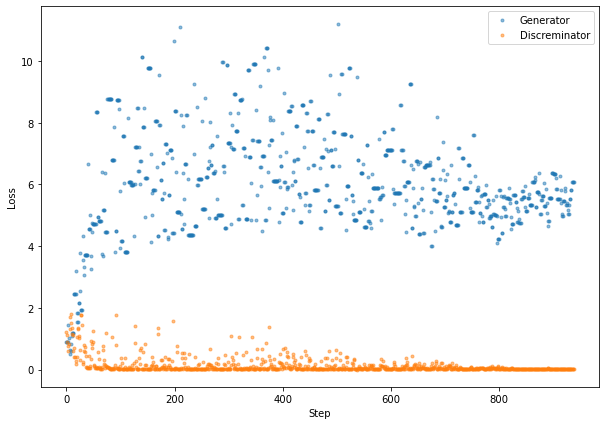

In [26]:
# 预测曲线
plt.figure(figsize = (10, 7))
plt.plot([i[1] for i in results], '.', label = 'Generator', alpha = 0.5)
plt.plot([i[0] for i in results], '.', label = 'Discreminator', alpha = 0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# 导入之前训练了第一百次的参数

In [27]:
PATHG='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'
PATHD='E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netD_epoch_99.pth'

netG = torch.load(PATHG)
netD = torch.load(PATHD)

#conv1_weight_state.eval()
print("netG",netG)
print('netD',netD)

netG OrderedDict([('model.deconv1.weight', tensor([[[[-0.0501,  0.0959,  0.0276,  0.1531, -0.0239],
          [ 0.0344,  0.0925,  0.0754,  0.0474,  0.0739],
          [ 0.0817,  0.0517, -0.0690,  0.0456,  0.0285],
          [ 0.0287, -0.0328, -0.0360,  0.0473,  0.0156],
          [ 0.0330, -0.0082,  0.0257,  0.1119,  0.0196]],

         [[-0.0108, -0.1002,  0.0168,  0.1137, -0.1452],
          [ 0.0202,  0.0207,  0.0429, -0.0648, -0.1093],
          [ 0.0245, -0.0579, -0.0173,  0.0042,  0.0647],
          [-0.0388, -0.0967, -0.0237, -0.0124,  0.0463],
          [-0.0661, -0.0048,  0.0144,  0.0464,  0.0206]],

         [[-0.0378,  0.0585,  0.1136, -0.0038,  0.0906],
          [ 0.0281,  0.0484,  0.0430, -0.0406,  0.0118],
          [ 0.0189,  0.0551, -0.0622, -0.0526,  0.0063],
          [-0.0087,  0.0733,  0.0452, -0.0431,  0.0555],
          [ 0.0540,  0.0977,  0.0089, -0.0341,  0.0631]],

         ...,

         [[-0.1326, -0.0497, -0.0329, -0.0206,  0.0187],
          [-0.0082, -0.0

# 运行之前保存的完成的模型
## 将其中模型训练的部分注释

In [31]:
# 构建一个生成器模型，并加载到GPU上
#netG = ModelG().cuda() if use_cuda else ModelG()
# 初始化网络的权重
#netG.apply(weight_init)
print(netG)

# 构建一个辨别器网络，并加载的GPU上
#netD=ModelD().cuda() if use_cuda else ModelD()
# 初始化权重
#netD.apply(weight_init)
#
# 要优化两个网络，所以需要有两个优化器
# 使用Adam优化器，可以自动调节收敛速度
#optimizerD=optim.SGD(netD.parameters(),lr=0.0002)
#optimizerG=optim.SGD(netG.parameters(),lr=0.0002)
optimizerD=optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))  #优化器
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))


# 模型的输入输出
# 生成一个随机噪声输入给生成器
noise=torch.tensor((batch_size, input_dim, 1, 1), dtype = torch.float)
print("随机噪声",noise)
#固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
print("固定噪声",fixed_noise)
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()


#BCE损失函数
criterion=nn.BCELoss()
error_G = None #总误差
num_epochs = 1 #训练周期
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
     #   print("data",data)
     #   print("target",target)
        #训练辨别器网络
        #清空梯度
        optimizerD.zero_grad()
        #1、输入真实图片
        data,target = data.clone().detach().requires_grad_(True), target.clone().detach()
      #  print("data",data)
      #  print("target",target)
        # 用于鉴别赝品还是真品的标签
        label = torch.ones(data.size()[0])  #正确的标签是1（真实）
        label = label.cuda() if use_cuda else label
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
      #  netD.train()
        
        output=netD(data) #放到辨别网络里辨别
        
        
        #计算损失函数
        label.data.fill_(1)
        error_real=criterion(output, label)  #损失函数
        error_real.backward() #辨别器的反向误差传播
        D_x=output.data.mean()
        
        #2、用噪声生成一张假图片
        with torch.no_grad():
            noise.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1) #噪声是一个input_dim维度的向量
        #喂给生成器生成图像
        fake_pic=netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2=netD(fake_pic) #用辨别器识别假图像
        label.data.fill_(0) #正确的标签应该是0（伪造）
        error_fake=criterion(output2,label) #计算损失函数
        error_fake.backward() #反向传播误差
        error_D=error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step() #开始优化
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad() #清空生成器梯度

            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1) #分类标签全部标为1，即真实图像
            noise.data.normal_(0,1) #重新随机生成一个噪声向量
     #       netG.train()
            fake_pic=netG(noise) #生成器生成一张伪造图像
            output=netD(fake_pic) #辨别器进行分辨
            error_G=criterion(output,label) #辨别器的损失函数
            error_G.backward() #反向传播
            optimizerG.step() #优化网络
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        # 记录数据
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader),
                error_D.data.item(), 
                error_G.data.item()))
    #生成一些随机图片，但因输出到文件
    netG.eval()
    fake_u=netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)

    #挑选一些真实数据中的图像图像保存
    data, _ = next(iter(train_loader))
  #  vutil.save_image(img,'temp/fake_test%s.png'% (epoch))
    # 保存网络状态到硬盘文件
  #  torch.save(netG.state_dict(), '%s/netG_epoch_%d_test1.pth' % ('net', epoch))
  #  torch.save(netD.state_dict(), '%s/netD_epoch_%d_test1.pth' % ('net', epoch))
    if epoch == 0:
        img = make_show(data.clone().detach().requires_grad_(True))
     #   vutil.save_image(img,'temp/real_test1%s.png' % (epoch))

ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)
随机噪声 tensor([ 64., 100.,   1.,   1.])
固定噪声 tensor([[[[ 0.0134]],

         [[-0.3159]],

         [[ 1.4779]],

         ...,

         [[ 0.3197]],

         [[ 1.5601]],

         [[ 0.5643]]],


        [[[-1.1686]],

         [[-0.4972]],

         [[-1.3877]],

         ...,

         [[-1.4425]],

         [[-0.1521]],

         [[ 0.4963]]],


        [[[ 0.1271]],

         [[ 0.7379]],

         [[-1.7842]],

   

# 查看训练100次的模型结果
Loss基本都是0，看来还不错的

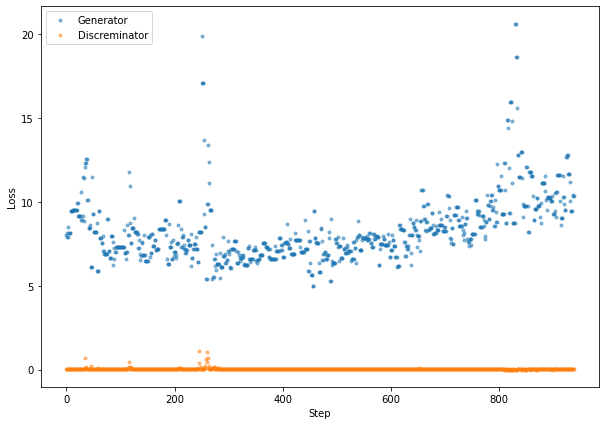

In [32]:
# 预测曲线
plt.figure(figsize = (10, 7))
plt.plot([i[1] for i in results], '.', label = 'Generator', alpha = 0.5)
plt.plot([i[0] for i in results], '.', label = 'Discreminator', alpha = 0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

In [54]:
for var_name in optimizer.state_dict():
 print(var_name,'\t',optimizer.state_dict()[var_name])

state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


# 查看保存的模型参数

In [45]:
test=ModelG()
test.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
print(test.state_dict())

OrderedDict([('model.deconv1.weight', tensor([[[[-0.0501,  0.0959,  0.0276,  0.1531, -0.0239],
          [ 0.0344,  0.0925,  0.0754,  0.0474,  0.0739],
          [ 0.0817,  0.0517, -0.0690,  0.0456,  0.0285],
          [ 0.0287, -0.0328, -0.0360,  0.0473,  0.0156],
          [ 0.0330, -0.0082,  0.0257,  0.1119,  0.0196]],

         [[-0.0108, -0.1002,  0.0168,  0.1137, -0.1452],
          [ 0.0202,  0.0207,  0.0429, -0.0648, -0.1093],
          [ 0.0245, -0.0579, -0.0173,  0.0042,  0.0647],
          [-0.0388, -0.0967, -0.0237, -0.0124,  0.0463],
          [-0.0661, -0.0048,  0.0144,  0.0464,  0.0206]],

         [[-0.0378,  0.0585,  0.1136, -0.0038,  0.0906],
          [ 0.0281,  0.0484,  0.0430, -0.0406,  0.0118],
          [ 0.0189,  0.0551, -0.0622, -0.0526,  0.0063],
          [-0.0087,  0.0733,  0.0452, -0.0431,  0.0555],
          [ 0.0540,  0.0977,  0.0089, -0.0341,  0.0631]],

         ...,

         [[-0.1326, -0.0497, -0.0329, -0.0206,  0.0187],
          [-0.0082, -0.0226, 

In [53]:
for param_tensor in test.model.state_dict():
 print(param_tensor,'\t',test.model.state_dict()[param_tensor].size())

print(test.model.deconv1)
print(test.model.deconv1.bias)

deconv1.weight 	 torch.Size([100, 128, 5, 5])
bnorm1.weight 	 torch.Size([128])
bnorm1.bias 	 torch.Size([128])
bnorm1.running_mean 	 torch.Size([128])
bnorm1.running_var 	 torch.Size([128])
bnorm1.num_batches_tracked 	 torch.Size([])
deconv2.weight 	 torch.Size([128, 64, 5, 5])
bnorm2.weight 	 torch.Size([64])
bnorm2.bias 	 torch.Size([64])
bnorm2.running_mean 	 torch.Size([64])
bnorm2.running_var 	 torch.Size([64])
bnorm2.num_batches_tracked 	 torch.Size([])
deconv3.weight 	 torch.Size([64, 1, 4, 4])
ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
None


# 因为不知道怎么使用modeld.state_dict()拿的这个做的实验

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
 
 
# define model
class TheModelClass(nn.Module):
 def __init__(self):
  super(TheModelClass,self).__init__()
  self.conv1 = nn.Conv2d(3,6,5)
  self.pool = nn.MaxPool2d(2,2)
  self.conv2 = nn.Conv2d(6,16,5)
  self.fc1 = nn.Linear(16*5*5,120)
  self.fc2 = nn.Linear(120,84)
  self.fc3 = nn.Linear(84,10)
 
 def forward(self,x):
  x = self.pool(F.relu(self.conv1(x)))
  x = self.pool(F.relu(self.conv2(x)))
  x = x.view(-1,16*5*5)
  x = F.relu(self.fc1(x))
  x = F.relu(self.fc2(x))
  x = self.fc3(x)
  return x
 
# initial model
model = TheModelClass()
 
#initialize the optimizer
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
 
# print the model's state_dict
print("model's state_dict:")
for param_tensor in model.state_dict():
 print(param_tensor,'\t',model.state_dict()[param_tensor].size())
 
print("\noptimizer's state_dict")
for var_name in optimizer.state_dict():
 print(var_name,'\t',optimizer.state_dict()[var_name])
 
print("\nprint particular param")
print('\n',model.conv1.weight.size())
print('\n',model.conv1.weight)
 
print("------------------------------------")
torch.save(model.state_dict(),'./model_state_dict.pt')
# model_2 = TheModelClass()
# model_2.load_state_dict(torch.load('./model_state_dict'))
# model.eval()
# print('\n',model_2.conv1.weight)
# print((model_2.conv1.weight == model.conv1.weight).size())
## 仅仅加载某一层的参数
conv1_weight_state = torch.load('./model_state_dict.pt')['conv1.weight']
print(conv1_weight_state==model.conv1.weight)
 
model_2 = TheModelClass()
model_2.load_state_dict(torch.load('./model_state_dict.pt'))
model_2.conv1.requires_grad=False
print(model_2.conv1.requires_grad)
print(model_2.conv1.bias.requires_grad)

model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])

optimizer's state_dict
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

print particular param

 torch.Size([6, 3, 5, 5])

 Parameter containing:
tensor([[[[-0.0452, -0.0405, -0.0417, -0.0577,  0.0192],
          [-0.0240, -0.0626,  0.0080, -0.0803,  0.0872],
          [-0.0083,  0.0372,  0.0828,  0.0176, -0.1119],
          [ 0.0164, -0.1079, -0.0353, -0.0317, -0.0702],
          [-0.0468,  0.0980,  0.0867,  0.0726, -0.0908]],

         [[ 0.0381, -0.0083, -0.0752,  0.0806,  0.0519],
          [ 0.0322, -0.0879,  0.0897,  0.1068, -0.11

In [58]:
netG=ModelG()
netG.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
print(netG.state_dict())

netD=ModelD()
netD.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netD_epoch_99.pth'))
print(netD.state_dict())


OrderedDict([('model.deconv1.weight', tensor([[[[-0.0501,  0.0959,  0.0276,  0.1531, -0.0239],
          [ 0.0344,  0.0925,  0.0754,  0.0474,  0.0739],
          [ 0.0817,  0.0517, -0.0690,  0.0456,  0.0285],
          [ 0.0287, -0.0328, -0.0360,  0.0473,  0.0156],
          [ 0.0330, -0.0082,  0.0257,  0.1119,  0.0196]],

         [[-0.0108, -0.1002,  0.0168,  0.1137, -0.1452],
          [ 0.0202,  0.0207,  0.0429, -0.0648, -0.1093],
          [ 0.0245, -0.0579, -0.0173,  0.0042,  0.0647],
          [-0.0388, -0.0967, -0.0237, -0.0124,  0.0463],
          [-0.0661, -0.0048,  0.0144,  0.0464,  0.0206]],

         [[-0.0378,  0.0585,  0.1136, -0.0038,  0.0906],
          [ 0.0281,  0.0484,  0.0430, -0.0406,  0.0118],
          [ 0.0189,  0.0551, -0.0622, -0.0526,  0.0063],
          [-0.0087,  0.0733,  0.0452, -0.0431,  0.0555],
          [ 0.0540,  0.0977,  0.0089, -0.0341,  0.0631]],

         ...,

         [[-0.1326, -0.0497, -0.0329, -0.0206,  0.0187],
          [-0.0082, -0.0226, 

In [60]:
# 构建一个生成器模型，并加载到GPU上
#netG = ModelG().cuda() if use_cuda else ModelG()
# 初始化网络的权重
#netG.apply(weight_init)
print(netG)

# 构建一个辨别器网络，并加载的GPU上
#netD=ModelD().cuda() if use_cuda else ModelD()
# 初始化权重
#netD.apply(weight_init)
#
# 要优化两个网络，所以需要有两个优化器
# 使用Adam优化器，可以自动调节收敛速度
#optimizerD=optim.SGD(netD.parameters(),lr=0.0002)
#optimizerG=optim.SGD(netG.parameters(),lr=0.0002)
optimizerD=optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))  #优化器
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))


# 模型的输入输出
# 生成一个随机噪声输入给生成器
noise=torch.tensor((batch_size, input_dim, 1, 1), dtype = torch.float)
print("随机噪声",noise)
#固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
print("固定噪声",fixed_noise)
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()


#BCE损失函数
criterion=nn.BCELoss()
error_G = None #总误差
num_epochs = 1 #训练周期
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
     #   print("data",data)
     #   print("target",target)
        #训练辨别器网络
        #清空梯度
        optimizerD.zero_grad()
        #1、输入真实图片
        data,target = data.clone().detach().requires_grad_(True), target.clone().detach()
      #  print("data",data)
      #  print("target",target)
        # 用于鉴别赝品还是真品的标签
        label = torch.ones(data.size()[0])  #正确的标签是1（真实）
        label = label.cuda() if use_cuda else label
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
      #  netD.train()
        
        output=netD(data) #放到辨别网络里辨别
        
        
        #计算损失函数
        label.data.fill_(1)
        error_real=criterion(output, label)  #损失函数
        error_real.backward() #辨别器的反向误差传播
        D_x=output.data.mean()
        
        #2、用噪声生成一张假图片
        with torch.no_grad():
            noise.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1) #噪声是一个input_dim维度的向量
        #喂给生成器生成图像
        fake_pic=netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2=netD(fake_pic) #用辨别器识别假图像
        label.data.fill_(0) #正确的标签应该是0（伪造）
        error_fake=criterion(output2,label) #计算损失函数
        error_fake.backward() #反向传播误差
        error_D=error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step() #开始优化
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad() #清空生成器梯度

            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1) #分类标签全部标为1，即真实图像
            noise.data.normal_(0,1) #重新随机生成一个噪声向量
     #       netG.train()
            fake_pic=netG(noise) #生成器生成一张伪造图像
            output=netD(fake_pic) #辨别器进行分辨
            error_G=criterion(output,label) #辨别器的损失函数
            error_G.backward() #反向传播
            optimizerG.step() #优化网络
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        # 记录数据
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader),
                error_D.data.item(), 
                error_G.data.item()))
    #生成一些随机图片，但因输出到文件
    netG.eval()
    fake_u=netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    
    

    #挑选一些真实数据中的图像图像保存
    data, _ = next(iter(train_loader))
    vutil.save_image(img,'temp/fake_test_later%s.png'% (epoch))
    # 保存网络状态到硬盘文件
  #  torch.save(netG.state_dict(), '%s/netG_epoch_%d_test1.pth' % ('net', epoch))
  #  torch.save(netD.state_dict(), '%s/netD_epoch_%d_test1.pth' % ('net', epoch))
    if epoch == 0:
        img = make_show(data.clone().detach().requires_grad_(True))
        vutil.save_image(img,'temp/real_test1_later%s.png' % (epoch))

ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)
随机噪声 tensor([ 64., 100.,   1.,   1.])
固定噪声 tensor([[[[ 0.6096]],

         [[-0.1487]],

         [[-0.1299]],

         ...,

         [[ 0.6910]],

         [[ 0.7088]],

         [[-1.8813]]],


        [[[-0.3319]],

         [[ 0.3344]],

         [[ 0.2283]],

         ...,

         [[-2.2536]],

         [[ 1.3239]],

         [[ 0.2723]]],


        [[[ 1.2502]],

         [[ 0.8048]],

         [[-0.8571]],

   

In [ ]:
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
fixed_noise

# 模型生成随机生成的噪声的图

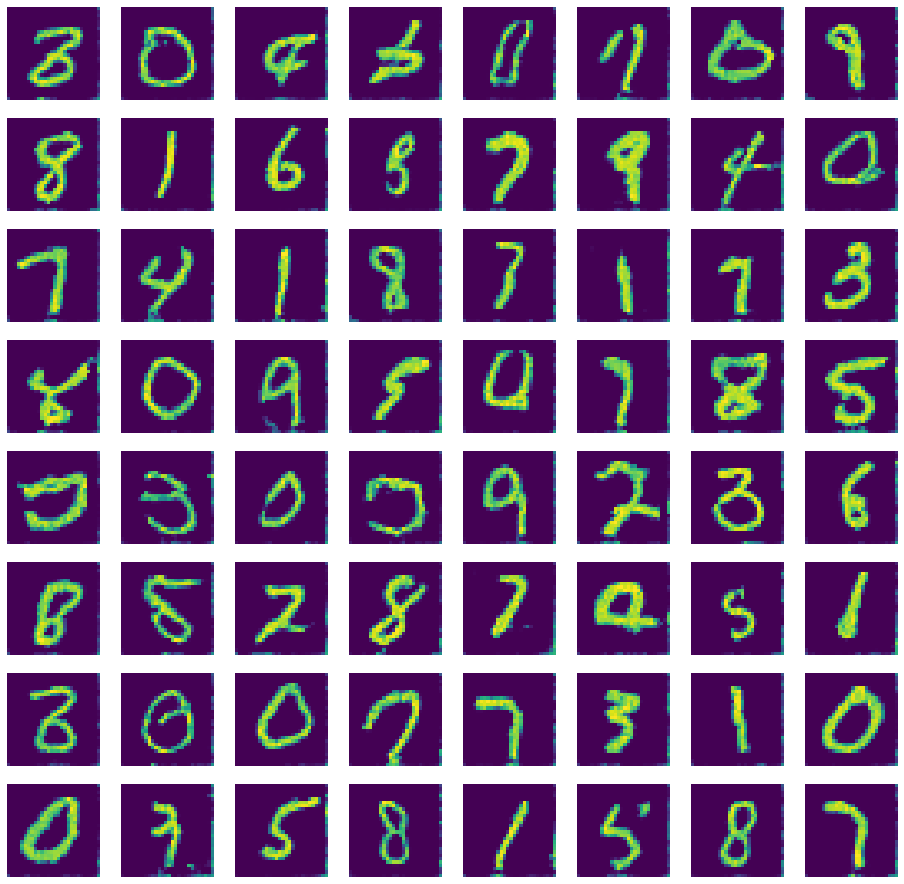

In [162]:
netG=ModelG()
netG.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True)
netG.eval()
fake_u=netG(fixed_noise)  #fixed_noise  这个是训练了100次的模型（导入了第一百次的参数）
fake_u = fake_u.cpu() if use_cuda else fake_u
img = make_show(fake_u)
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#print(img.size())
#因为输入的sample_size是64，所以设置成8*8
f, axarr = plt.subplots(8,8, sharex=True, figsize=(16,16))  #排列的大小，还有画布的大小
for i in range(batch_size):
    axarr[i // 8, i % 8].axis('off')
    imshow(img[i].data, None,axarr[i // 8, i % 8])

# 由于没有设置标签，且这个是随机生成的
# 想办法可以输入一个数字然后生成一张数字图

In [157]:
#查看fixed_noise是什么样子的
for i in range(64):
    print(fixed_noise[0][i])
fixed_noise[0]

tensor([[1.5864]], grad_fn=<SelectBackward>)
tensor([[1.3867]], grad_fn=<SelectBackward>)
tensor([[-0.2673]], grad_fn=<SelectBackward>)
tensor([[-1.4790]], grad_fn=<SelectBackward>)
tensor([[-0.2683]], grad_fn=<SelectBackward>)
tensor([[-0.1816]], grad_fn=<SelectBackward>)
tensor([[-1.1843]], grad_fn=<SelectBackward>)
tensor([[1.0224]], grad_fn=<SelectBackward>)
tensor([[2.6990]], grad_fn=<SelectBackward>)
tensor([[-0.5840]], grad_fn=<SelectBackward>)
tensor([[0.2115]], grad_fn=<SelectBackward>)
tensor([[0.5988]], grad_fn=<SelectBackward>)
tensor([[-0.7004]], grad_fn=<SelectBackward>)
tensor([[1.1169]], grad_fn=<SelectBackward>)
tensor([[-1.3792]], grad_fn=<SelectBackward>)
tensor([[0.7334]], grad_fn=<SelectBackward>)
tensor([[-0.4369]], grad_fn=<SelectBackward>)
tensor([[0.4958]], grad_fn=<SelectBackward>)
tensor([[-1.1563]], grad_fn=<SelectBackward>)
tensor([[1.0159]], grad_fn=<SelectBackward>)
tensor([[0.3908]], grad_fn=<SelectBackward>)
tensor([[0.1015]], grad_fn=<SelectBackward>)


tensor([[[ 1.5864]],

        [[ 1.3867]],

        [[-0.2673]],

        [[-1.4790]],

        [[-0.2683]],

        [[-0.1816]],

        [[-1.1843]],

        [[ 1.0224]],

        [[ 2.6990]],

        [[-0.5840]],

        [[ 0.2115]],

        [[ 0.5988]],

        [[-0.7004]],

        [[ 1.1169]],

        [[-1.3792]],

        [[ 0.7334]],

        [[-0.4369]],

        [[ 0.4958]],

        [[-1.1563]],

        [[ 1.0159]],

        [[ 0.3908]],

        [[ 0.1015]],

        [[-2.1980]],

        [[ 2.5261]],

        [[-0.3771]],

        [[ 0.7077]],

        [[-0.1419]],

        [[-0.8547]],

        [[ 0.8652]],

        [[-0.9616]],

        [[-0.5087]],

        [[ 1.2025]],

        [[-0.1475]],

        [[-0.1712]],

        [[ 0.6131]],

        [[-0.5413]],

        [[ 0.3406]],

        [[-0.9971]],

        [[ 0.3459]],

        [[ 0.9386]],

        [[-1.1009]],

        [[ 2.4939]],

        [[ 0.3630]],

        [[ 0.5075]],

        [[-0.2302]],

        [[

9
tensor([[[[ 0.0328]],

         [[-0.6739]],

         [[ 0.1922]],

         [[-2.2125]],

         [[ 0.9880]],

         [[-0.5721]],

         [[ 0.3347]],

         [[ 0.2493]],

         [[-0.0259]],

         [[ 1.1062]],

         [[-0.7111]],

         [[-0.8494]],

         [[ 0.4481]],

         [[ 0.3230]],

         [[-0.8893]],

         [[ 0.3558]],

         [[-0.8056]],

         [[ 0.0302]],

         [[-0.7744]],

         [[-1.3398]],

         [[-0.6479]],

         [[-0.5392]],

         [[-0.4093]],

         [[-0.2655]],

         [[ 1.0573]],

         [[ 0.5603]],

         [[-2.0547]],

         [[-0.2005]],

         [[-1.0678]],

         [[-0.1649]],

         [[-0.7919]],

         [[ 1.9254]],

         [[-0.2488]],

         [[-0.6901]],

         [[ 0.0301]],

         [[ 0.9328]],

         [[-1.9443]],

         [[ 1.3495]],

         [[ 2.0543]],

         [[-0.9294]],

         [[-0.5052]],

         [[ 0.0075]],

         [[ 0.6033]],

         

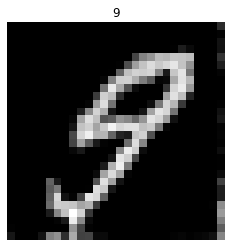

In [255]:
#fixed_noise=torch.FloatTensor(1, input_dim, 1, 1).normal_(1,1).requires_grad_(True)
input_num=int(input())
fixed_noise = torch.FloatTensor([input_num]).resize_(1,100,1,1).clone().normal_(0,1)

netG.eval()
print(fixed_noise)
fake_u=netG(fixed_noise)  #fixed_noise  这个是训练了100次的模型（导入了第一百次的参数）
print(fake_u)
fake_u = fake_u.cpu() if use_cuda else fake_u
print(fake_u)
img = make_show(fake_u)
#img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#print(img.size())
#因为输入的sample_size是64，所以设置成8*8
plt.axis('off')
imshow(img[0],input_num, plt.gca())

# 没有增加normal_输入自己的数字，expand 别的值是直接复制的

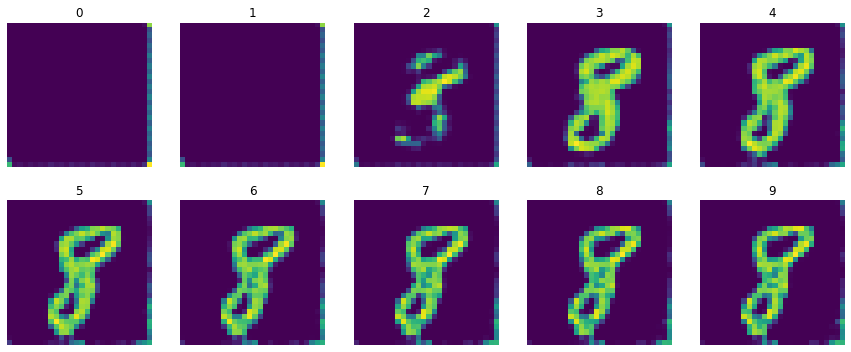

In [140]:
"""#fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True) 100
batch = next(iter(test_loader))
indx = torch.nonzero(batch[1] == 1)
data = batch[0][indx[0]]
input_x = data.clone().detach().requires_grad_(True)
input_x = input_x.cuda() if use_cuda else input_x
input_x
netG.eval()
fake_u=netG(input_x)  #fixed_noise
fake_u = fake_u.cpu() if use_cuda else fake_u
img = make_show(fake_u)
vutil.save_image(img,'temp/模型最终1.png')
"""
netG=ModelG()
netG.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
samples = torch.FloatTensor([0,1,2,3,4,5,6,7,8,9])
samples = samples.type(dtype).clone()
sample_size = 10
samples.resize_(sample_size,1,1,1)
samples = samples.expand(sample_size, input_dim, 1, 1).clone().detach() #.detach()
samples = samples.cuda() if use_cuda else samples
fake_u = netG(samples)
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
f, axarr = plt.subplots(2,5, sharex=True, figsize=(15,6))
for i in range(sample_size):
    axarr[i // 5, i % 5].axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int), axarr[i // 5, i % 5])

# 增加了normal_，图片效果不错，但是不能输入自己想要的数字
里面生成都数字还是挺逼真的

tensor([[[[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [

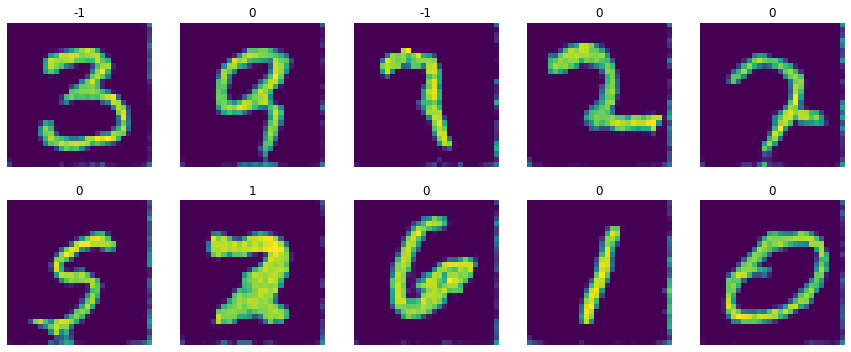

In [145]:
"""#fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1).requires_grad_(True) 100
batch = next(iter(test_loader))
indx = torch.nonzero(batch[1] == 1)
data = batch[0][indx[0]]
input_x = data.clone().detach().requires_grad_(True)
input_x = input_x.cuda() if use_cuda else input_x
input_x
netG.eval()
fake_u=netG(input_x)  #fixed_noise
fake_u = fake_u.cpu() if use_cuda else fake_u
img = make_show(fake_u)
vutil.save_image(img,'temp/模型最终1.png')
"""
netG=ModelG()
netG.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
samples = torch.FloatTensor([0,1,2,3,4,5,6,7,8,9])
samples = samples.type(dtype).clone()
sample_size = 10
samples.resize_(sample_size,1,1,1)
samples = samples.expand(sample_size, input_dim, 1, 1).clone().detach().normal_(0,1)
print(samples)
samples=samples.normal_(0,1) #.detach()
print(samples)
samples = samples.cuda() if use_cuda else samples
fake_u = netG(samples)
fake_u = fake_u.cpu() if use_cuda else fake_u
samples = samples.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
f, axarr = plt.subplots(2,5, sharex=True, figsize=(15,6))
for i in range(sample_size):
    axarr[i // 5, i % 5].axis('off')
    imshow(img[i].data, samples.data.numpy()[i][0,0,0].astype(int), axarr[i // 5, i % 5])


# 以下是拿来测试的

In [117]:
samples = torch.FloatTensor([0,1,2,3,4,5,6,7,8,9])
samples = samples.type(dtype).clone()
sample_size = 10
samples.resize_(sample_size,1,1,1)
print(samples)
samples.resize_(sample_size,1,1,1).normal_(0,1)
print(samples)


tensor([[[[0.]]],


        [[[1.]]],


        [[[2.]]],


        [[[3.]]],


        [[[4.]]],


        [[[5.]]],


        [[[6.]]],


        [[[7.]]],


        [[[8.]]],


        [[[9.]]]])
tensor([[[[-0.8342]]],


        [[[ 0.0795]]],


        [[[-0.3329]]],


        [[[-0.8026]]],


        [[[ 0.3848]]],


        [[[-0.5803]]],


        [[[-2.0486]]],


        [[[ 2.5241]]],


        [[[ 0.5066]]],


        [[[-0.3714]]]])
